In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def lqr(A, B, F, N, N_T):
    """
    Calculate the feedback gains by backpropagation of the Riccati equation
    Accept:
        F: state cost in final position, size (n,n)
        A: dynamics matrix, size (n,n)
        B: input matrix, size (n,d)
        N: cost of control, size (d,d)
        N_T: number of time steps, int.
    Returns:
        V: sequence of cost matrices, size (n,n,N_T)
        L: sequence of feedback matrix, size (d,n,N_T)
    """
    n, d = B.shape
    V = np.zeros((n,n,N_T))
    L = np.zeros((d,n,N_T))
    
    V[:,:,-1] = F
    # Run backward in time
    for t in range(N_T-2,0,-1):
        """ Your code here """
        V[:,:,t] =  A.T @ V[:,:,t+1] @ A - A.T @ V[:,:,t+1] @ B @ np.linalg.inv(N + B.T @ V[:,:,t+1] @ B) @ B.T @ V[:,:,t+1] @ A
        L[:,:,t] = np.linalg.inv(N + B.T @ V[:,:,t+1] @ B) @ B.T @ V[:,:,t+1] @ A
    return V, L

In [12]:
def simulate(x0, x0_est, A_real, A, B, C, L, 
                obs_noise, dyn_noise, init_var,dt):
    """
    Simultaneously simulate the trajectory forward and estimate the state
    Accepts:
        x0: initial position, size (n, )
        x0_est: estimate of initial position, size (n, )
        A_real: dynamics matrix - real, size (n,n)
        A: dynamics matrix - assumed, size (n,n)
        B: input matrix, size (n,d)
        C: observation matrix, size (d, n)
        L: sequence of feedback matrices, size (d, n, N_T)
        obs_noise: observation noise, float >=0
        dyn_noise: dynamics noise, float >=0
        init_var: initial variance of filter, float >=0
    Returns:
        x: true state, size (n, N_T)
        x_est: estimated state, size (n, N_T)
        x_var_est: sequence of posterior variances, size (n, n, N_T)
        kalman_gain: feedback matrices, size (n, d, N_T)
        u: controls, size (d, N_T)
    """
    # Initialize variables
    d, n, N_T = L.shape
    x = np.zeros((n,N_T))
    u = np.zeros((d,N_T-1))
    x_est = np.zeros((n,N_T))
    x_var_est = np.zeros((n,n,N_T))
    kalman_gain = np.zeros((n,d,N_T))

    x[:,0] = x0 # the true state
    x_est[:,0] = x0_est # system does not know where it is
    x_var_est[:,:,0] = init_var * np.eye(n) # very large state uncertainty at the beginning. 
    # observation noise matrix
    Q = obs_noise * dt * np.eye(d)
    # dynamics noise matrix
    R = dyn_noise * dt * np.eye(n)

    # Run forward in time
    for t in range(1, N_T):
        """ Your code here """
        # compute the control
        u[:,t-1] = -L[:,:,t-1] @ x_est[:,t-1]
        # compute the true state
        x[:,t] = A_real @ x[:,t-1] + B @ u[:,t-1] + np.random.multivariate_normal(np.zeros(n), R)
        # compute the observation
        y = C @ x[:,t] + np.random.multivariate_normal(np.zeros(d), Q)
        # compute the Kalman gain
        kalman_gain[:,:,t] = x_var_est[:,:,t-1] @ C.T @ np.linalg.inv(Q + C @ x_var_est[:,:,t-1] @ C.T)
        # compute the estimated state
        x_est[:,t] = A @ x_est[:,t-1] + B @ u[:,t-1] + kalman_gain[:,:,t] @ (y - C @ A @ x_est[:,t-1] - C @ B @ u[:,t-1])
        # compute the variance of the estimated state
        x_var_est[:,:,t] = (np.eye(n) - kalman_gain[:,:,t] @ C) @ x_var_est[:,:,t-1] @ (np.eye(n) - kalman_gain[:,:,t] @ C).T + kalman_gain[:,:,t] @ Q @ kalman_gain[:,:,t].T

    return x, x_est, x_var_est, kalman_gain, u

Text(0, 0.5, 'velocity')

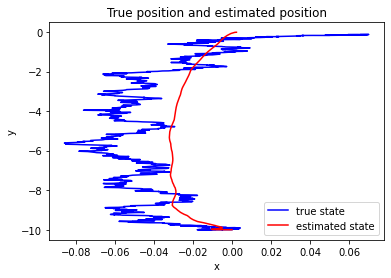

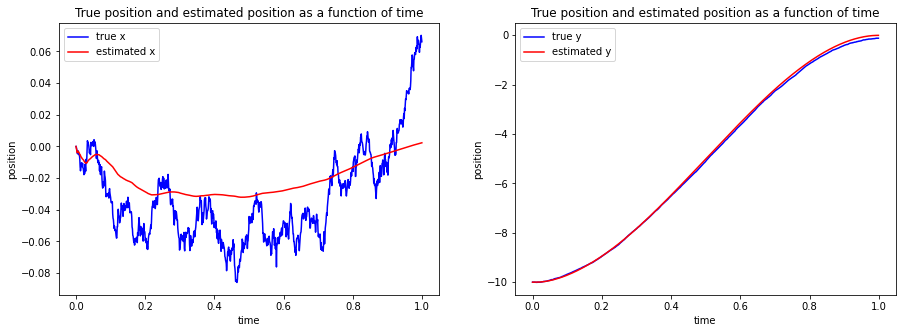

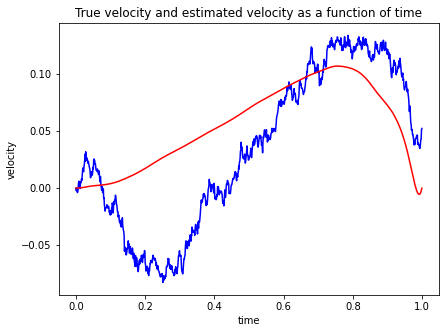

In [19]:
x0 = np.array([0,-10 , 0, 0])
dt = 0.001
T=1
N_T = int(T/dt)
obs_noise = 0.01
dyn_noise = 0.01
m=1
f0=0
A=np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, -f0*dt/m], [0, 0, f0*dt/m, 1]])
B=np.array([[0, 0],[0, 0],[dt/m, 0],[0, dt/m]])
C=np.array([[1, 0, 0, 0],[0, 1, 0, 0]])
F=1e+8*np.eye(4)
N=np.eye(2)
x0_est=x0
init_var=1e-3*np.eye(4)
A_real=A
v, L = lqr(A, B, F, N, N_T)
x, x_est, x_var_est, kalman_gain, u = simulate(x0, x0_est, A_real, A, B, C, L,
                                                obs_noise, dyn_noise, init_var, dt)
# Plot the true state and the estimated state
plt.figure()
plt.title('True position and estimated position')
plt.plot(x[0,:], x[1,:], 'b', label='true state')
plt.plot(x_est[0,:], x_est[1,:], 'r', label='estimated state')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('True position and estimated position as a function of time')
plt.plot(np.arange(N_T)*dt, x[0,:], 'b', label='true x')
plt.plot(np.arange(N_T)*dt, x_est[0,:], 'r', label='estimated x')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()

plt.subplot(1,2,2)
plt.title('True position and estimated position as a function of time')
plt.plot(np.arange(N_T)*dt, x[1,:], 'b', label='true y')
plt.plot(np.arange(N_T)*dt, x_est[1,:], 'r', label='estimated y')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('True velocity and estimated velocity as a function of time')
plt.plot(np.arange(N_T)*dt, x[2,:], 'b', label='true vx')
plt.plot(np.arange(N_T)*dt, x_est[2,:], 'r', label='estimated vx')
plt.xlabel('time')
plt.ylabel('velocity')


